# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

In [2]:
!pip install -q -r requirements.txt

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu117 (from versions: 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==2.0.1+cu117


### Test for *CUDA*

In [1]:
import torch

torch.cuda.is_available(), torch.cuda.device_count()

(True, 1)

### Load the Data

In [31]:
import torchvision.transforms
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# If you want to refresh how to load and split data in pytorch, open the helpers.py file
# and read the code. We have documented it with comments so you can follow along easily
train_dl, valid_dl = get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers=0)
test_dl = get_test_data_loader(batch_size, transforms, num_workers=0)

# For convenience let's group them together in a dictionary
data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_dl), len(valid_dl), len(test_dl)

(2000, 500, 500)

In [4]:
2000 * 20, 500 * 20

(40000, 10000)

In [5]:
# Image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Visualize a Batch of Training Data

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub=None):
    img = img / 2 + 0.5 # unnormalize
    img = np.transpose(img, axes=(1, 2, 0))
    
    if not sub:
        plt.imshow(img)
        plt.axis("off")
    else:
        sub.imshow(img)
        sub.axis("off")

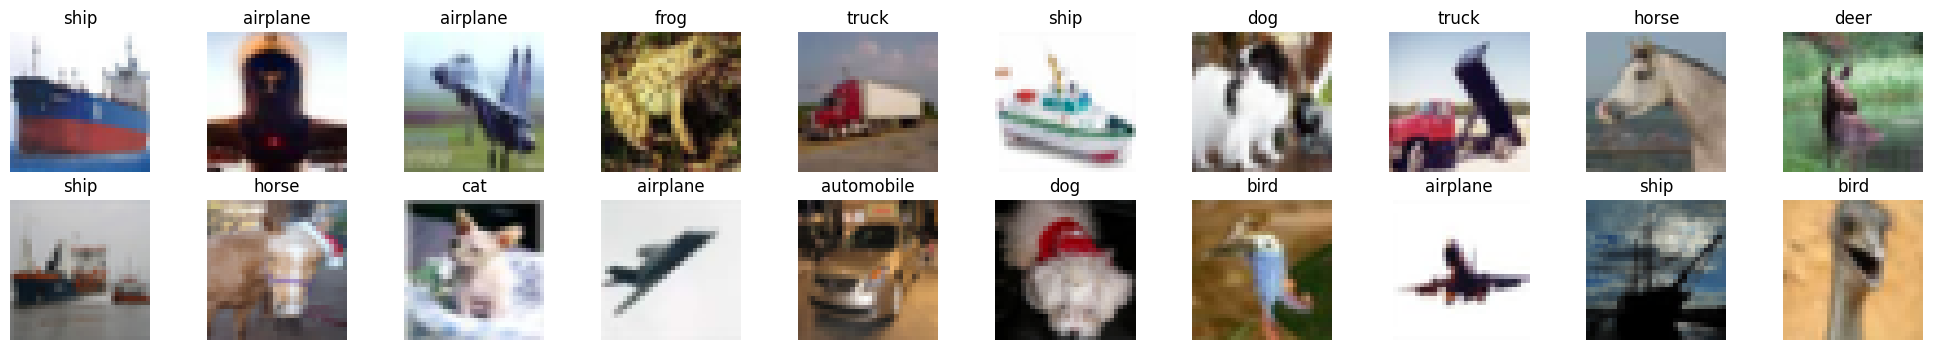

In [8]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# 20 images
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

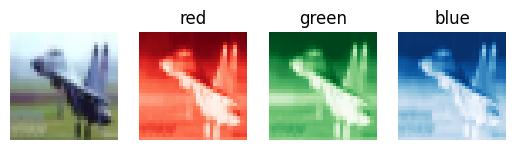

In [9]:
rgb_img = np.squeeze(images[2])
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

fig, subs = plt.subplots(1, 4) 

for i, sub in enumerate(subs.flatten()):
    
    if i == 0:
        imshow(rgb_img, sub)
    else:
        img = rgb_img[i-1]
        sub.imshow(img, cmap=cmaps[i])
        sub.set_title(channels[i])
        sub.axis("off")

frog  frog  frog  frog  frog  frog  airplane frog  frog  frog  cat   frog  cat   frog  deer  frog  dog   automobile frog  automobile


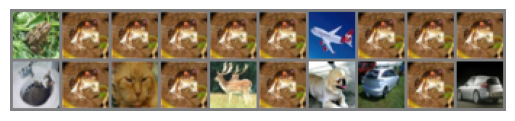

In [21]:
import torchvision

images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=10))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [22]:
images[0].shape

torch.Size([3, 32, 32])

## Define the Network Architecture

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_classes=10):
        
        super(Net, self).__init__()
        
        # Conv layer 1 sees 3x32x32 image tensor
        # and produces 16 feature maps 32x32 (i.e., tensor 16x32x32)
        # padding is set to 1 to make the feature map dimension match the input
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        # 2x2 pooling with stride 2. it seas a 16x32x32 tensor
        # and halves their size, (i.e., tensor 16x16x16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv layer 2 sees a 16x16x16 tensor
        # and produces 32 feature maps 16x16 (i.e., tensor 32x16x16)
        self.conv1 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.Relu()

        # produces feature map tensor 32x8x8
        self.pool2 = nn.MaxPool2d(2, 2)

        # Conv layer 3 in(32x8x8) out(64x8x8)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU()

        # produces feature map tensor 64x4x4
        self.pool3 = nn.MaxPool2d(2, 2)

        # Linear layer (64 * 4 * 4 = 1024) -> 500
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 500)
        self.dp1 = nn.Dropout2d(p=0.5)
        self.rl1 = nn.ReLU()

        # Linear layer 500 -> 10
        self.fc2 = nn.Linear(500, n_classes)
        
    def forward(self, x):
        x = self.relu1(self.pool1(self.conv1(x)))
        x = self.relu2(self.pool2(self.conv2(x)))
        x = self.relu3(self.pool3(self.conv3(x)))

        x = self.flatten(x)
        x = self.rl1(self.dp1(self.fc1(x)))

        x = self.fc2(x)
        
        return x

# using sequential
class Net(nn.Module):
    def __init__(self, n_classes=10):
        
        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*4*4, 500),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(500, out_features=n_classes),
        )

    def forward(self, x):
        
        return self.model(x)

model = Net()
print(model)

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model.cuda()

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=500, out_features=10, bias=True)
  )
)


## How many parameters

In [24]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

541094

In [25]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")

In [26]:
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                  [-1, 500]         512,500
          Dropout-12                  [-1, 500]               0
             ReLU-13                  [-1, 500]               0
           Linear-14                   

## Specify loss function and optimizer

In [27]:
# categorical cross entropy
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Train the network

In [32]:
from helpers import optimize

In [33]:
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x18863b1bdf0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x18863b1bf10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x18863b3a6b0>}

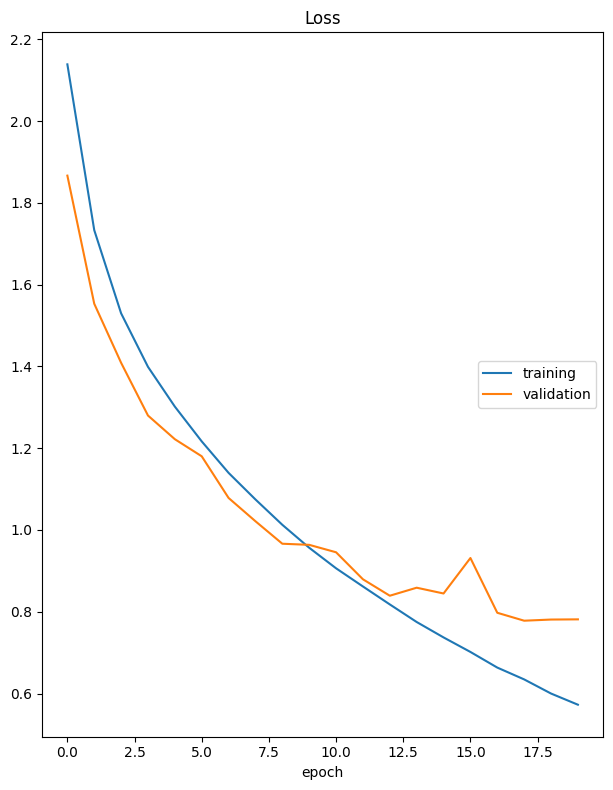

Loss
	training         	 (min:    0.573, max:    2.139, cur:    0.573)
	validation       	 (min:    0.778, max:    1.867, cur:    0.781)


In [34]:
optimize(
    data_loaders, 
    model, 
    optimizer, 
    loss, 
    n_epochs=20, 
    save_path="cifar10_best_valid.pt", 
    interactive_tracking=True
)